In [1]:
import os;
os.environ['CUDA_VISIBLE_DEVICES']="0"
import numpy as np
print(os.environ['CUDA_VISIBLE_DEVICES'])

0


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter

# Load train data
Dataset = pd.read_csv('PTB_XL_Dataset.csv')  

# Split into features and labels
X_train = Dataset.iloc[:, :187]  
y_train = Dataset.loc[:, ['NORM','MI', 'CD', 'HYP', 'STTC']]  

# Split the data into train and test sets, maintaining the same label distribution
_, _, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=50)

# Change Data to numpy array
X_test = np.array(X_test)
y_test = np.array(y_test)

# Reshape data for tensors
X_test_reshaped = X_test.reshape(-1, 1, 187)
y_test_reshaped = y_test.reshape(-1, 1, 1)

In [7]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, filters, kernel_size):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(filters, filters, kernel_size, padding='same')
        self.conv2 = nn.Conv1d(filters, filters, kernel_size, padding='same')
        self.activation = nn.ReLU()
        self.max_pooling = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.activation(out)
        out = self.conv2(out)
        out += residual  # Residual connection
        out = self.activation(out)
        out = self.max_pooling(out)
        return out

class ConvResNet(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(ConvResNet, self).__init__()
        self.conv1 = nn.Conv1d(input_shape[0], 32, 5, padding='same')
        self.activation = nn.ReLU()
        self.residual_blocks = nn.ModuleList([ResidualBlock(32, 5) for _ in range(5)])
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        for block in self.residual_blocks:
            x = block(x)
        x = self.flatten(x)
        return x

# Define input shape (assuming each beat is a 1D signal with a certain length)
input_shape = (1, 187)  # Update input_shape accordingly
num_classes = 5  # Change num_classes according to your task
model1 = ConvResNet(input_shape, num_classes)

# Print model summary
print(model1)


ConvResNet(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=same)
  (activation): ReLU()
  (residual_blocks): ModuleList(
    (0-4): 5 x ResidualBlock(
      (conv1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=same)
      (conv2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=same)
      (activation): ReLU()
      (max_pooling): MaxPool1d(kernel_size=5, stride=2, padding=2, dilation=1, ceil_mode=False)
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [8]:
# Assuming model1 is your pretrained model
pretrained_model = model1

# Define new layers to add for fine-tuning
num_fine_tune_features = 192
fine_tune_layers = nn.Sequential(
    nn.Linear(num_fine_tune_features, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
)

class ModifiedModel(nn.Module):
    def __init__(self, existing_model, new_layers):
        super(ModifiedModel, self).__init__()
        self.existing_model = existing_model
        self.new_layers = new_layers

    def forward(self, x):
        x = self.existing_model(x)
        x = self.new_layers(x)
        return x
model_NORM = ModifiedModel(pretrained_model, fine_tune_layers)
model_MI = ModifiedModel(pretrained_model, fine_tune_layers)
model_CD = ModifiedModel(pretrained_model, fine_tune_layers)
model_HYP = ModifiedModel(pretrained_model, fine_tune_layers)
model_STTC = ModifiedModel(pretrained_model, fine_tune_layers)

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR

# Convert data to PyTorch tensors
test_data_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32)
test_labels_tensor = torch.tensor(y_test, dtype=torch.long)

# Define dataset and DataLoader for test data
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=1024)

# List of models and corresponding weight file paths
models = [
    {'model': model_NORM, 'weights': 'best_model_NORM.pth'},  # Model 1 for class NORM
    {'model': model_MI, 'weights': 'best_model_MI.pth'},  # Model 2 for class MI
    {'model': model_CD, 'weights': 'best_model_CD.pth'},  # Model 3 for class CD
    {'model': model_HYP, 'weights': 'best_model_HYP.pth'},  # Model 4 for class HYP
    {'model': model_STTC, 'weights': 'best_model_STTC.pth'}   # Model 5 for class STTC
]

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Iterate through each model and its respective weights
for model_info in models:
    # Load the model and its weights
    model = model_info['model']
    weights_path = model_info['weights']
    model.load_state_dict(torch.load(weights_path))
    model.to(device)  # Move model to device (e.g., GPU)

    # Set model to evaluation mode
    model.eval()

    # Evaluate the model on the test data
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Apply sigmoid function to logits to obtain probabilities
            probabilities = torch.sigmoid(outputs)

            # Store the true and predicted labels
            true_labels.append(labels.cpu().numpy())
            predicted_labels.append(probabilities.cpu().numpy())

# Convert predicted labels from concatenated outputs
true_labels = np.concatenate(true_labels)
true_labels = true_labels[:len(y_test)]
predicted_labels = np.concatenate(predicted_labels)
predicted_labels = np.ravel(predicted_labels)
predicted_labels_reshape = np.zeros((len(true_labels), 5))
for i in range(5):  
    predicted_labels_reshape[:, i] = predicted_labels[i*len(true_labels):(i+1)*len(true_labels)]
    
predicted_labels = predicted_labels_reshape
predicted_labels_ = (predicted_labels > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels_)
precision = precision_score(true_labels, predicted_labels_, average='macro')
recall = recall_score(true_labels, predicted_labels_, average='macro')
f1 = f1_score(true_labels, predicted_labels_, average='macro')
classification_rep = classification_report(true_labels, predicted_labels_, target_names=['NORM', 'MI', 'CD', 'HYP', 'STTC'])

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:")
print(classification_rep)



Accuracy: 0.4469
Precision: 0.5773
Recall: 0.7738
F1 Score: 0.6471
Classification Report:
              precision    recall  f1-score   support

        NORM       0.78      0.89      0.83     12317
          MI       0.53      0.74      0.62      5740
          CD       0.73      0.77      0.75      9075
         HYP       0.23      0.67      0.34      2891
        STTC       0.62      0.80      0.70      8991

   micro avg       0.61      0.80      0.69     39014
   macro avg       0.58      0.77      0.65     39014
weighted avg       0.65      0.80      0.71     39014
 samples avg       0.66      0.81      0.70     39014



/home/jupyter-mmelbadr/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


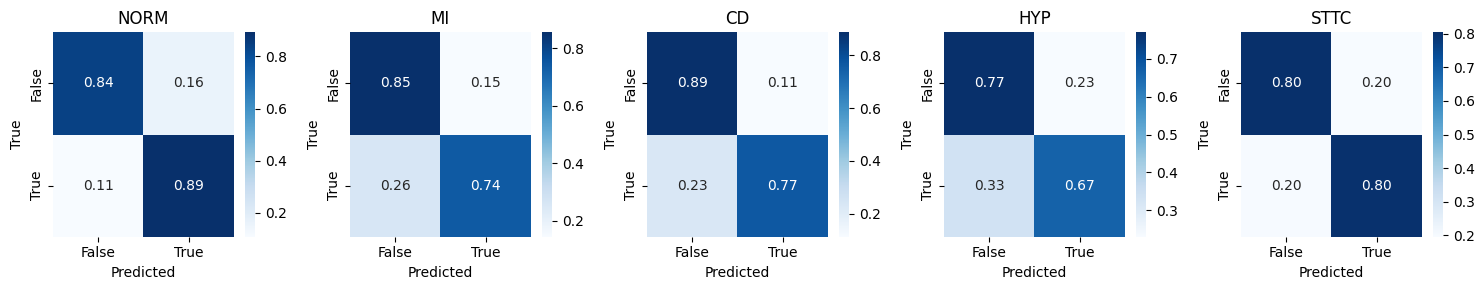

In [11]:
# Define class labels
class_labels = ['NORM', 'MI','CD', 'HYP', 'STTC']  # Modify this list as needed

# Calculate multilabel confusion matrices
ml_conf_matrices = multilabel_confusion_matrix(true_labels, predicted_labels_)

# Iterate through each confusion matrix and plot it
num_labels = ml_conf_matrices.shape[0]
fig, axes = plt.subplots(1, num_labels, figsize=(15, 3))

for i in range(num_labels):
    # Get confusion matrix for the i-th label
    cm = ml_conf_matrices[i].astype(float)
    cm[0] = cm[0]/(cm[0][0]+cm[0][1])
    cm[1] = cm[1]/(cm[1][0]+cm[1][1])
    # Plot the heatmap
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[i],
                xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    
    # Set title and labels for the plot
    axes[i].set_title(f'{class_labels[i]}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

# Show the plot
plt.tight_layout()
plt.show()

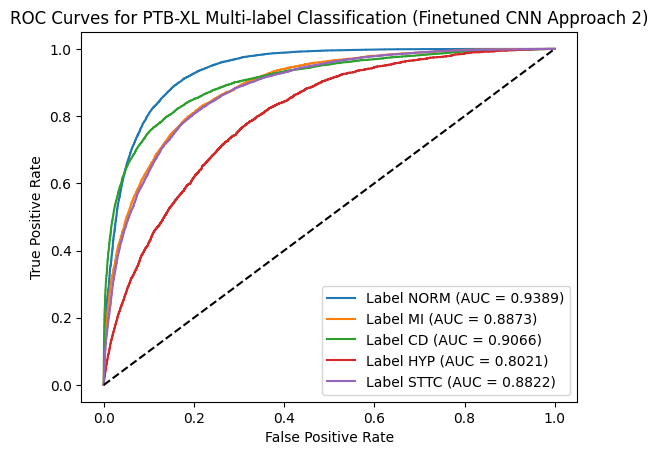

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

# Calculate and plot ROC curve and AUC score for each label
auc_scores = []
num_labels = y_test.shape[1]

# Create a new figure for plotting all ROC curves
plt.figure()

for i in range(num_labels):
    # Get the probabilities for the current label
    y_prob_label = predicted_labels[:, i]
    
    # Calculate the ROC curve and AUC score for the current label
    fpr, tpr, thresholds = roc_curve(y_test[:, i], y_prob_label)
    auc_score = roc_auc_score(y_test[:, i], y_prob_label)
    auc_scores.append(auc_score)
    
    # Plot the ROC curve for the current label
    plt.plot(fpr, tpr, label=f"Label {class_labels[i]} (AUC = {auc_score:.4f})")

# Plot the diagonal line (random performance)
plt.plot([0, 1], [0, 1], 'k--')

# Add labels, title, and legend to the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for PTB-XL Multi-label Classification (Finetuned CNN Approach 2)')
plt.legend()
# Show the plot
plt.show()



In [14]:
import numpy as np
from sklearn.metrics import accuracy_score

# Assuming true_labels and predicted_labels are arrays or DataFrames with the same shape

# Initialize a list to store per-label accuracy
per_label_accuracy = []

# Iterate through each label (column)
for i in range(true_labels.shape[1]):
    # Get the true and predicted labels for the current label
    true_label = true_labels[:, i]
    predicted_label_ = predicted_labels_[:, i]
    
    # Calculate the accuracy for the current label
    accuracy = accuracy_score(true_label, predicted_label_)
    
    # Append the accuracy to the list
    per_label_accuracy.append(accuracy)

# Convert the list of accuracies to a numpy array for convenience (optional)
per_label_accuracy = np.array(per_label_accuracy)

# Print per-label accuracy
for i, accuracy in enumerate(per_label_accuracy):
    print(f"Accuracy for {class_labels[i]}: {accuracy:.4f}")
print(f"Average Accuracy: {np.mean(per_label_accuracy):.4f}")
# Calculate the average AUC-ROC score across all labels
average_auc = np.mean(auc_scores)

# Print the average AUC-ROC score
print(f"Average AUC-ROC score: {average_auc:.4f}")

auc_score_ovr = roc_auc_score(y_test, predicted_labels, average = 'macro', multi_class='ovr')
auc_score_ovo = roc_auc_score(y_test, predicted_labels, average = 'macro', multi_class='ovo')

print(f"ROC-AUC-OVO Score {auc_score_ovo:.4f}")
print(f"ROC-AUC-OVR Score {auc_score_ovr:.4f}")

Accuracy for NORM: 0.8612
Accuracy for MI: 0.8340
Accuracy for CD: 0.8530
Accuracy for HYP: 0.7610
Accuracy for STTC: 0.8036
Average Accuracy: 0.8226
Average AUC-ROC score: 0.8834
ROC-AUC-OVO Score 0.8834
ROC-AUC-OVR Score 0.8834
